# 🌍 Proyecto de Data Science y Machine Learning: Meteosat + FAOSTAT

Este proyecto combina **datos satelitales de Meteosat** y **datos agrícolas de FAOSTAT** para realizar un análisis de tendencias y aplicar técnicas de **Machine Learning**.  

El objetivo principal es:

- Integrar información satelital y de producción agrícola.  
- Limpiar y normalizar los datos de diferentes fuentes.  
- Realizar análisis exploratorio y visualizaciones.  
- Construir modelos de Machine Learning para predicción y análisis de patrones.

---

## 📦 Instalación de librerías necesarias

Para trabajar con los datos de Meteosat, FAOSTAT y Python, asegúrate de tener instaladas las siguientes librerías. Se recomienda crear un entorno virtual en Anaconda para evitar conflictos:

```bash
# Instalar librerías básicas
pip install pandas numpy matplotlib seaborn scikit-learn

# Librerías específicas para Meteosat
pip install satpy xarray netCDF4 rasterio cartopy



In [1]:
pip install meteostat

Note: you may need to restart the kernel to use updated packages.


# 🌍 Análisis Climático y Datos de FAOSTAT

Se realiza un **análisis de datos climáticos históricos** de varios países europeos, combinando información de **Meteostat** con datos de **FAOSTAT**.  
El objetivo es preparar un **dataset consolidado** que permita estudios de tendencias climáticas, producción agrícola y análisis de Machine Learning posteriormente.

Se utilizará la librería [**Meteostat**](https://dev.meteostat.net/python/) para obtener datos meteorológicos diarios, que luego se agregan por año calendario para cada país.  
El análisis incluye variables como:

- Temperatura promedio (`tavg`)  
- Temperatura mínima (`tmin`)  
- Temperatura máxima (`tmax`)  
- Precipitación total anual (`prcp`) 

In [13]:
from meteostat import Point, Daily
import pandas as pd
import datetime as dt

# Período de interés
start = dt.datetime(2000, 1, 1)
end = dt.datetime(2023, 12, 31)

# Coordenadas aproximadas de algunos países europeos
countries = {
    'Spain': (40.0, -4.0),
    'France': (46.0, 2.0),
    'Italy': (42.5, 12.5),
    'Portugal': (39.5, -8.0),
}

all_weather = []

for country, (lat, lon) in countries.items():
    loc = Point(lat, lon)
    data = Daily(loc, start, end).fetch()

    # Si no hay datos, saltar el país
    if data.empty:
        print(f"⚠️ No hay datos para {country}")
        continue

    # Aseguramos que el índice sea tipo datetime
    data.index = pd.to_datetime(data.index)

    # Agrupar por año calendario ('YE' = año que termina en diciembre)
    yearly = data.resample('YE').agg({
        'tavg': 'mean',
        'tmin': 'mean',
        'tmax': 'mean',
        'prcp': 'sum'
    })

    # Crear columna 'year' desde el índice
    yearly['year'] = yearly.index.year
    yearly['country'] = country

    all_weather.append(yearly.reset_index(drop=True))

# Concatenar todos los países
weather_df = pd.concat(all_weather, ignore_index=True)
weather_df.head()


⚠️ No hay datos para Portugal


,tavg,tmin,tmax,prcp,year,country
0,16.99493,9.218306,22.428689,331.1,2000,Spain
1,10.515278,9.850137,22.211781,340.1,2001,Spain
2,11.925,9.91863,22.26,362.9,2002,Spain
3,13.4,10.270685,22.886849,300.3,2003,Spain
4,14.0,9.150546,22.101093,399.7,2004,Spain


## 🌾 Carga y preparación de datos agrícolas de FAOSTAT

En esta sección se cargan los datos de **FAOSTAT**, que contienen información histórica de producción y rendimiento agrícola por país y cultivo.  
El objetivo es extraer únicamente los datos relevantes para análisis posteriores junto con los datos climáticos de Meteostat.

Pasos realizados en este bloque:

1. **Cargar CSV de FAOSTAT**  
   - Se importa el archivo CSV descargado de FAOSTAT con datos de rendimiento (`Yield`).

2. **Filtrar por información relevante**  
   - Solo se conservan los registros cuyo elemento (`Element`) sea `"Yield"`, es decir, rendimiento por cultivo.

3. **Renombrar columnas**  
   - Se ajustan los nombres de columnas para facilitar la combinación (`merge`) con el dataset climático:
     - `Area` → `country`  
     - `Item` → `crop`  
     - `Year` → `year`  
     - `Value` → `yield`

4. **Seleccionar columnas clave**  
   - Solo se mantienen: `country`, `crop`, `year`, `yield`.

5. **Limpiar datos de texto**  
   - Se eliminan espacios extra en nombres de países y cultivos para evitar errores al hacer merge con otros datasets.

> 📌 Resultado: un DataFrame limpio con columnas consistentes listo para combinar con los datos climáticos y realizar análisis de Machine Learning.


In [14]:
import pandas as pd

# Cargar el CSV (ajusta el nombre si es distinto)
faostat = pd.read_csv("FAOSTAT_data_en_10-19-2025.csv")

# Nos quedamos solo con la información relevante
faostat = faostat[faostat["Element"] == "Yield"]

# Renombrar columnas para facilitar el merge
faostat = faostat.rename(columns={
    "Area": "country",
    "Item": "crop",
    "Year": "year",
    "Value": "yield"
})

# Nos quedamos con columnas clave
faostat = faostat[["country", "crop", "year", "yield"]]

# Limpiar espacios o nombres inconsistentes
faostat["country"] = faostat["country"].str.strip()
faostat["crop"] = faostat["crop"].str.strip()

faostat.head()


,country,crop,year,yield
1,France,Grapes,2000,9016.0
4,France,Grapes,2001,8388.5
7,France,Grapes,2002,7954.6
10,France,Grapes,2003,7409.6
13,France,Grapes,2004,8879.3


## 🔗 Unión de datos agrícolas y climáticos

En esta sección combinamos los datos de **rendimiento agrícola de FAOSTAT** con los **datos climáticos de Meteostat** para cada país y año.  
El objetivo es obtener un dataset consolidado que permita análisis estadístico y modelos de Machine Learning considerando tanto clima como rendimiento de cultivos.

Pasos realizados:

1. **Homogeneizar el tipo de dato de la columna `year`**  
   - Se asegura que la columna `year` sea de tipo entero (`int`) en ambos DataFrames (`faostat` y `weather_df`) para evitar errores al hacer merge.

2. **Merge por país y año**  
   - Se combinan los datasets utilizando `pd.merge` con las columnas clave:
     - `country`  
     - `year`  
   - Tipo de merge: `inner`, para conservar solo los registros que tienen datos tanto climáticos como agrícolas.

> 📌 Resultado: un DataFrame `merged` que contiene, por país y año, información de rendimiento agrícola junto con variables climáticas promedio, listo para análisis exploratorio y Machine Learning.



In [15]:
# Aseguramos que 'year' sea del mismo tipo
faostat["year"] = faostat["year"].astype(int)
weather_df["year"] = weather_df["year"].astype(int)

# Merge por país y año
merged = pd.merge(faostat, weather_df, on=["country", "year"], how="inner")

merged.head()


,country,crop,year,yield,tavg,tmin,tmax,prcp
0,France,Grapes,2012,7077.5,10.177219,4.580952,15.865397,0.0
1,France,Grapes,2013,7285.3,10.050138,5.438348,15.560767,0.0
2,France,Grapes,2014,8193.0,11.316898,6.001475,16.964897,0.0
3,France,Grapes,2015,8321.2,11.264045,5.38635,17.138279,0.0
4,France,Grapes,2016,8022.1,10.638227,5.176023,16.54883,0.0


## 🤖 Modelo de Machine Learning: Predicción de rendimiento agrícola

En esta sección se construye un **modelo de regresión supervisada** para predecir el rendimiento (`yield`) de los cultivos utilizando variables climáticas y el tipo de cultivo.  
Se utiliza **Random Forest Regressor** por su capacidad de manejar relaciones no lineales y múltiples variables.

Pasos realizados:

1. **Codificación de variables categóricas**  
   - La columna `crop` (tipo de cultivo) se convierte en variables dummy (`pd.get_dummies`) para que el modelo pueda procesarlas numéricamente.  
   - `drop_first=True` evita la multicolinealidad.

2. **Definir variables predictoras (`X`) y objetivo (`y`)**  
   - `X`: columnas climáticas (`tavg`, `tmin`, `tmax`, `prcp`) + variables dummy de cultivos.  
   - `y`: rendimiento agrícola (`yield`).

3. **División de datos en entrenamiento y prueba**  
   - `train_test_split` se usa con `test_size=0.2` (20% para prueba) y `random_state=42` para reproducibilidad.

4. **Entrenamiento del modelo**  
   - Se crea un **RandomForestRegressor** con 200 árboles (`n_estimators=200`).  
   - Se ajusta el modelo con `X_train` y `y_train`.

5. **Predicción y evaluación**  
   - Se predice `y_pred` sobre el conjunto de prueba (`X_test`).  
   - Métricas calculadas:
     - **MAE (Mean Absolute Error)**: promedio del error absoluto.  
     - **R² (R squared)**: proporción de varianza explicada por el modelo.

> 📌 Resultado: el modelo permite estimar el rendimiento de los cultivos considerando el clima y el tipo de cultivo, y las métricas MAE y R² indican la precisión de las predicciones.


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Convertimos los cultivos (categorías) a variables numéricas
merged = pd.get_dummies(merged, columns=["crop"], drop_first=True)

# Variables predictoras (X) y objetivo (y)
X = merged[["tavg", "tmin", "tmax", "prcp"] + [col for col in merged.columns if "crop_" in col]]
y = merged["yield"]

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
model = RandomForestRegressor(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Predicciones
y_pred = model.predict(X_test)

# Métricas
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")


MAE: 978.86
R²: 0.977


## 📊 Visualización de resultados del modelo

En esta sección se evalúa visualmente la calidad del modelo de **Random Forest** mediante un **scatter plot** que compara los valores reales del rendimiento (`y_test`) con las predicciones (`y_pred`).

Pasos y objetivos:

1. **Gráfico de dispersión (`scatter`)**  
   - Cada punto representa un registro del conjunto de prueba.  
   - Eje X: valor real del rendimiento agrícola.  
   - Eje Y: valor predicho por el modelo.

2. **Interpretación**  
   - Si el modelo fuera perfecto, todos los puntos caerían sobre la **línea diagonal** (predicción = valor real).  
   - La dispersión de los puntos indica el **grado de error** del modelo.  
   - La transparencia (`alpha=0.7`) permite visualizar mejor la densidad de puntos.

3. **Conclusión visual**  
   - Este gráfico permite identificar patrones, posibles desviaciones sistemáticas o errores del modelo, y complementar las métricas numéricas (MAE y R²) con una interpretación visual.



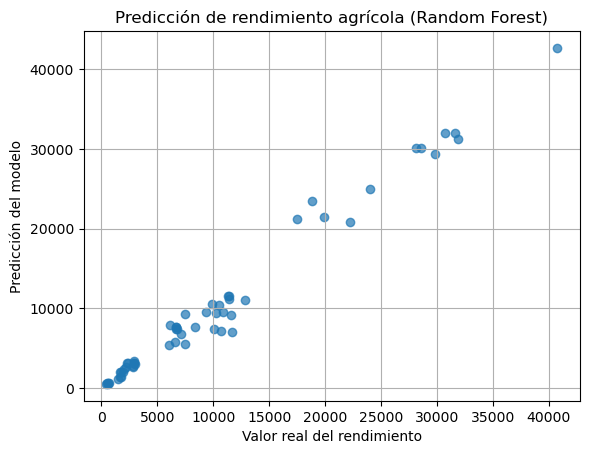

In [17]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Valor real del rendimiento")
plt.ylabel("Predicción del modelo")
plt.title("Predicción de rendimiento agrícola (Random Forest)")
plt.grid(True)
plt.show()


## 🌟 Importancia de las características en el modelo

En esta sección se analiza qué variables tienen mayor influencia en las predicciones del modelo de **Random Forest**.

Pasos realizados:

1. **Obtener importancia de las características**  
   - `model.feature_importances_` devuelve un valor para cada variable en `X` que indica su relevancia relativa en el modelo.

2. **Ordenar de mayor a menor**  
   - Se utiliza `np.argsort(importances)[::-1]` para listar primero las variables más importantes.

3. **Interpretación**  
   - Variables climáticas (`tavg`, `tmin`, `tmax`, `prcp`) y variables dummy de cultivos (`crop_*`) se evalúan según su contribución a la predicción del rendimiento (`yield`).  
   - Los valores más altos indican que la variable tiene mayor impacto en la predicción.

> 📌 Este análisis permite identificar qué factores (climáticos o tipo de cultivo) influyen más en el rendimiento agrícola según el modelo entrenado.


In [18]:
import numpy as np

importances = model.feature_importances_
features = X.columns
sorted_idx = np.argsort(importances)[::-1]

for i in sorted_idx:
    print(f"{features[i]}: {importances[i]:.3f}")


crop_Potatoes: 0.677
crop_Oranges: 0.159
tmin: 0.050
tmax: 0.045
crop_Maize (corn): 0.035
tavg: 0.009
crop_Olives: 0.008
crop_Pistachios, in shell: 0.008
prcp: 0.005
crop_Wheat: 0.005


## 🛠 Preparación de librerías para Machine Learning avanzado

En esta sección se importan todas las librerías necesarias para realizar **modelos de regresión supervisada**, evaluación de métricas y análisis de importancia de variables, así como visualización de resultados.

Librerías incluidas:

- **Pandas y NumPy**  
  - Para manejo de datos y operaciones numéricas.

- **Scikit-learn (`sklearn`)**  
  - `RandomForestRegressor`: modelo de regresión basado en árboles de decisión.  
  - `DummyRegressor`: para establecer una línea base simple de predicción.  
  - `train_test_split`: dividir los datos en entrenamiento y prueba.  
  - `cross_val_score`, `GroupKFold`, `TimeSeriesSplit`, `GridSearchCV`: validación cruzada y optimización de hiperparámetros.  
  - `mean_absolute_error`, `mean_squared_error`, `r2_score`: métricas de evaluación.  
  - `permutation_importance`, `PartialDependenceDisplay`: análisis de importancia e interpretabilidad del modelo.

- **Matplotlib**  
  - Para crear gráficos y visualizar resultados.

> 📌 Objetivo: Tener todas las herramientas listas para entrenar modelos, evaluar su rendimiento, analizar la importancia de las variables y realizar curvas de aprendizaje o estudios de dependencia parcial.

In [19]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score, GroupKFold, TimeSeriesSplit, GridSearchCV, learning_curve
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



## 🧩 Baseline para el modelo de rendimiento agrícola

Antes de entrenar modelos complejos, es importante establecer una **referencia simple** que nos permita evaluar si nuestro modelo realmente aporta valor.  
En esta sección se crea un **modelo baseline** usando `DummyRegressor` de Scikit-learn, que predice siempre la **media del rendimiento agrícola**.

Pasos realizados:

1. **Definir variables predictoras (`X`) y objetivo (`y`)**  
   - `X`: variables climáticas (`tavg`, `tmin`, `tmax`, `prcp`) + variables dummy de cultivos (`crop_*`).  
   - `y`: rendimiento agrícola (`yield`).

2. **Crear modelo baseline**  
   - `DummyRegressor(strategy='mean')` siempre predice la media de `y`.

3. **Validación cruzada**  
   - Se utiliza `cross_val_score` con 5 folds (`cv=5`) y scoring `neg_mean_absolute_error` para evaluar el error absoluto promedio del modelo baseline.

4. **Interpretación**  
   - Este valor de **MAE** sirve como referencia: cualquier modelo predictivo debe superar esta línea base para considerarse útil.

> 📌 Resultado: un valor de MAE que indica el error promedio esperado si simplemente se predice la media de los rendimientos, sin usar información climática ni del tipo de cultivo.

In [20]:
# X, y (usando las mismas variables que antes)
X = merged[["tavg", "tmin", "tmax", "prcp"] + [c for c in merged.columns if c.startswith("crop_")]]
y = merged["yield"]

# Baseline: predicción por la media
dummy = DummyRegressor(strategy='mean')
dummy_scores = -cross_val_score(dummy, X, y, cv=5, scoring='neg_mean_absolute_error')
print("Baseline MAE (mean predictor) (CV 5):", dummy_scores.mean())

Baseline MAE (mean predictor) (CV 5): 8964.495088740574


## ⏳ Validación cruzada para series temporales

En problemas con **datos temporales** como rendimiento agrícola y clima, es recomendable usar un esquema de validación que respete el **orden cronológico**.  
Aquí se utiliza `TimeSeriesSplit` para evaluar el modelo de manera adecuada.

Pasos realizados:

1. **Definir `TimeSeriesSplit`**  
   - `n_splits=5`: divide los datos en 5 particiones de entrenamiento/prueba, respetando el orden temporal.  
   - Esto evita que información futura “contamine” el entrenamiento con datos del pasado.

2. **Modelo de Random Forest**  
   - Se utiliza `RandomForestRegressor` con 200 árboles (`n_estimators=200`).  

3. **Evaluación con validación cruzada temporal**  
   - `cross_val_score` calcula el **MAE** promedio en cada split temporal.  
   - La media de estos scores proporciona una métrica más realista del error esperado en predicciones futuras.

> 📌 Resultado: el MAE obtenido con `TimeSeriesSplit` refleja cómo se comportaría el modelo al predecir años futuros usando solo datos históricos disponibles hasta ese punto.

In [21]:
# Ejemplo: ordenar por year y usar TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

model = RandomForestRegressor(n_estimators=200, random_state=42)
scores = -cross_val_score(model, X, y, cv=tscv, scoring='neg_mean_absolute_error')
print("TimeSeriesSplit MAE (CV):", scores.mean())


TimeSeriesSplit MAE (CV): 3803.014767046084


## 🏷 Validación cruzada por grupos (GroupKFold)

En este bloque se realiza una validación cruzada considerando **grupos**, en este caso **por país**, usando `GroupKFold`.  
Esto es útil cuando los datos tienen dependencias internas dentro de grupos, evitando que registros del mismo país aparezcan simultáneamente en entrenamiento y prueba.

Pasos realizados:

1. **Definir grupos**  
   - Cada país se considera un grupo (`groups = merged['country']`).  
   - `n_groups` obtiene el número de países únicos.  

2. **Crear GroupKFold**  
   - `n_splits = min(3, n_groups)` para asegurar que no haya más splits que grupos disponibles.  
   - Esto divide los datos de manera que en cada fold, todos los registros de un país estén **solo en entrenamiento o solo en prueba**.

3. **Evaluación con cross_val_score**  
   - Se calcula el **MAE** promedio respetando los grupos, evitando filtraciones de información entre entrenamiento y prueba.  

> 📌 Resultado: el MAE obtenido refleja cómo el modelo generaliza a países no vistos durante el entrenamiento, proporcionando una estimación más realista de su desempeño internacional.

In [22]:
groups = merged['country']
n_groups = merged['country'].nunique()
gkf = GroupKFold(n_splits=min(3, n_groups))  # o min(3, n_groups) para estar seguros
scores_group = -cross_val_score(model, X, y, cv=gkf.split(X, y, groups=groups), scoring='neg_mean_absolute_error')
print("GroupKFold (by country) MAE (CV):", scores_group.mean())


GroupKFold (by country) MAE (CV): 3366.5145854950383


## 📏 Evaluación final del modelo

En esta sección se calculan las métricas de desempeño del modelo de **Random Forest** sobre el conjunto de prueba (`y_test` y `y_pred`), proporcionando una visión completa de la precisión de las predicciones.

Métricas calculadas:

1. **MAE (Mean Absolute Error)**  
   - Promedio del error absoluto entre predicciones y valores reales.  
   - Indica cuánto se desvía en promedio la predicción del valor real.

2. **RMSE (Root Mean Squared Error)**  
   - Raíz cuadrada del error cuadrático medio.  
   - Penaliza más los errores grandes que el MAE, útil para detectar predicciones muy desviadas.

3. **R² (R squared)**  
   - Proporción de varianza de los datos explicada por el modelo.  
   - Valores cercanos a 1 indican un modelo que explica bien la variabilidad del rendimiento.  
   - Valores cercanos a 0 o negativos indican poca capacidad predictiva.

> 📌 Resultado: estas métricas permiten evaluar de manera integral la calidad de las predicciones, complementando la evaluación visual y los análisis de importancia de variables.

In [23]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def print_metrics(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))  # <- raíz cuadrada manual
    r2 = r2_score(y_true, y_pred)
    print(f"{prefix} MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}")

print_metrics(y_test, y_pred, "RandomForest (test)")



RandomForest (test) MAE: 978.860, RMSE: 1474.661, R²: 0.977


## 🌾 Evaluación del modelo por tipo de cultivo

En esta sección se calculan métricas de desempeño **separadas por cada cultivo**, para identificar si el modelo predice mejor ciertos cultivos que otros.

Pasos realizados:

1. **Reconstrucción del DataFrame de prueba**  
   - Se combina `X_test` con los valores reales (`yield_true`) y predicciones (`yield_pred`) para facilitar el análisis.

2. **Identificación del cultivo principal**  
   - Se utiliza la columna dummy de cultivos (`crop_*`) para determinar el cultivo correspondiente a cada fila.  
   - Si no hay columnas dummy, se recupera la información original de `merged` o se asigna `"unknown"`.

3. **Agrupación por cultivo**  
   - Se agrupa el DataFrame por `crop` y se calculan métricas para cada grupo:
     - **MAE**: error absoluto promedio  
     - **RMSE**: raíz del error cuadrático medio  
     - **R²**: proporción de varianza explicada

> 📌 Resultado: se obtiene una tabla con el desempeño del modelo por cultivo, lo que permite identificar cultivos que se predicen con mayor precisión y aquellos que podrían necesitar ajustes o más datos.

In [24]:
# Reconstruir test set DataFrame
test_df = X_test.copy()
test_df['yield_true'] = y_test.values
test_df['yield_pred'] = y_pred

# Columnas crop
crop_cols = [c for c in X.columns if c.startswith("crop_")]
if crop_cols:
    # obtener el nombre del cultivo principal
    test_df['crop'] = X_test[crop_cols].idxmax(axis=1).str.replace("crop_","")
else:
    test_df['crop'] = merged.loc[X_test.index, 'crop'] if 'crop' in merged.columns else 'unknown'

# Agrupar por cultivo
metrics_by_crop = test_df.groupby('crop').apply(lambda df: pd.Series({
    'MAE': mean_absolute_error(df['yield_true'], df['yield_pred']),
    'RMSE': np.sqrt(mean_squared_error(df['yield_true'], df['yield_pred'])),  # <- raíz cuadrada manual
    'R2': r2_score(df['yield_true'], df['yield_pred'])
}))

metrics_by_crop


,MAE,RMSE,R2
crop,,,
Maize (corn),1117.399899,1453.759069,0.560953
Olives,269.956077,298.195589,0.573607
Oranges,2557.546775,2963.842831,0.665547
"Pistachios, in shell",63.050600,68.582183,0.110115
Potatoes,1144.553500,1315.572894,0.888734
Wheat,466.081528,538.459304,0.924980


## 📉 Análisis de residuos del modelo

En esta sección se analizan los **residuos** del modelo, es decir, las diferencias entre los valores reales y las predicciones:

\[
\text{residuo} = y_{\text{true}} - y_{\text{pred}}
\]

Objetivos:

1. **Residual plot (scatter)**  
   - Se grafican los residuos frente a las predicciones (`y_pred`).  
   - Una línea horizontal en 0 indica donde los residuos serían nulos.  
   - Permite identificar **patrones no modelados** o **sesgos sistemáticos**:
     - Residuos dispersos aleatoriamente alrededor de 0 → buen ajuste.
     - Tendencias o formas específicas → posibles problemas de heterocedasticidad o falta de variables.

2. **Histograma de residuos**  
   - Muestra la **distribución de los errores**.  
   - Idealmente, los residuos deberían estar centrados en 0 y aproximadamente simétricos (distribución normal).  
   - Permite detectar **outliers** o sesgos en las predicciones.

> 📌 Resultado: este análisis visual ayuda a evaluar la calidad del modelo más allá de métricas numéricas, indicando si las predicciones son consistentes y sin patrones sistemáticos de error.

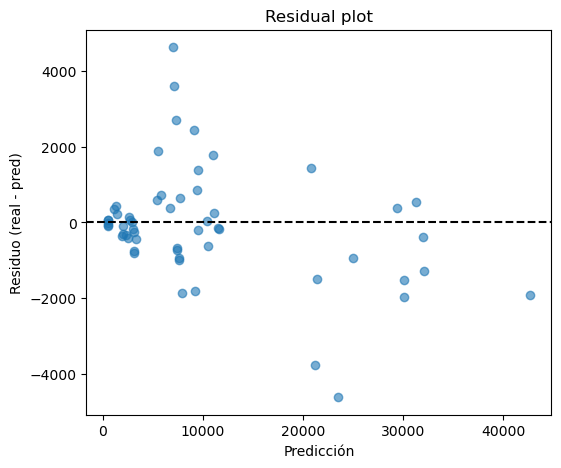

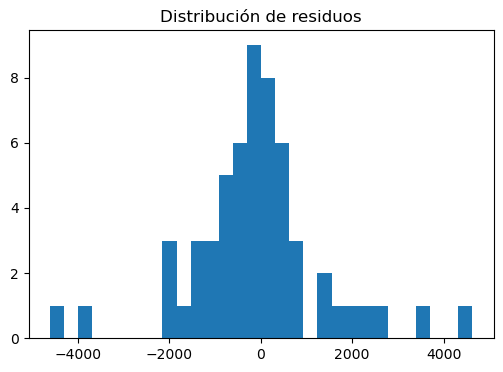

In [25]:
residuals = y_test - y_pred

plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color='k', linestyle='--')
plt.xlabel("Predicción")
plt.ylabel("Residuo (real - pred)")
plt.title("Residual plot")
plt.show()

# Histograma de residuos
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title("Distribución de residuos")
plt.show()


## 📈 Curva de aprendizaje del modelo

En esta sección se construye la **curva de aprendizaje** para el modelo de Random Forest, con el objetivo de evaluar cómo cambia el error del modelo según la cantidad de datos de entrenamiento.

Pasos realizados:

1. **Cálculo de la curva de aprendizaje**  
   - `learning_curve` divide los datos en diferentes tamaños de entrenamiento (`train_sizes`) y calcula el **MAE** en entrenamiento y validación cruzada (`cv=5`).  
   - Esto permite observar cómo mejora el desempeño del modelo a medida que se dispone de más datos.

2. **Promedio de scores**  
   - Se calcula la media de los MAE para cada tamaño de entrenamiento tanto en entrenamiento (`train_scores_mean`) como en validación (`test_scores_mean`).  
   - Los valores se convierten a positivos, ya que `learning_curve` devuelve `neg_mean_absolute_error`.

3. **Visualización**  
   - Se grafica MAE vs número de muestras de entrenamiento.  
   - Líneas:
     - **Train MAE**: error promedio en el conjunto de entrenamiento.  
     - **CV MAE**: error promedio en validación cruzada.

4. **Interpretación**  
   - Si las curvas se acercan y el error es bajo → buen ajuste y suficiente cantidad de datos.  
   - Si hay una gran diferencia entre entrenamiento y validación → posible **overfitting**.  
   - Si ambas curvas son altas y no mejoran con más datos → posible **underfitting**.

> 📌 Resultado: la curva de aprendizaje ayuda a decidir si agregar más datos o ajustar el modelo puede mejorar su desempeño.

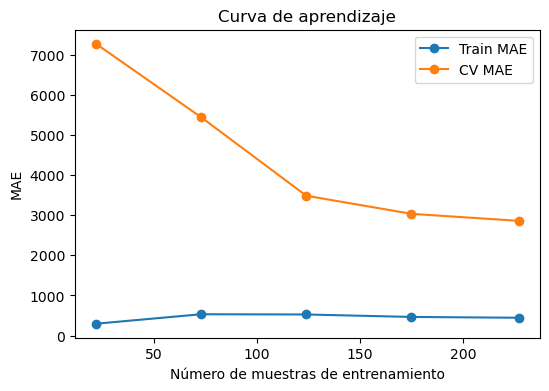

In [26]:
train_sizes, train_scores, test_scores = learning_curve(
    model, X, y, cv=5, scoring='neg_mean_absolute_error', train_sizes=np.linspace(0.1,1.0,5), random_state=42)

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_scores_mean, 'o-', label='Train MAE')
plt.plot(train_sizes, test_scores_mean, 'o-', label='CV MAE')
plt.xlabel("Número de muestras de entrenamiento")
plt.ylabel("MAE")
plt.legend()
plt.title("Curva de aprendizaje")
plt.show()


## ⚙️ Optimización de hiperparámetros con GridSearchCV

En esta sección se busca **mejorar el desempeño del modelo Random Forest** ajustando sus hiperparámetros mediante **GridSearchCV**.

Pasos realizados:

1. **Definir la malla de parámetros (`param_grid`)**  
   - `n_estimators`: número de árboles en el bosque ([100, 200]).  
   - `max_depth`: profundidad máxima de cada árbol ([None, 10, 20]).  
   - `min_samples_leaf`: número mínimo de muestras en una hoja ([1, 3]).

2. **Configuración de validación cruzada**  
   - `GridSearchCV` utiliza 3 folds por defecto (`cv=3`) y la métrica `neg_mean_absolute_error` para evaluar desempeño.  
   - `n_jobs=-1` permite usar todos los núcleos disponibles para acelerar el proceso.

3. **Entrenamiento y búsqueda de mejores parámetros**  
   - Se ajusta el modelo sobre `X_train` y `y_train`.  
   - `gs.best_score_` indica el MAE promedio más bajo obtenido en CV.  
   - `gs.best_params_` muestra la combinación de hiperparámetros que produjo ese resultado.

4. **Seleccionar el mejor modelo**  
   - `gs.best_estimator_` devuelve el modelo entrenado con los hiperparámetros óptimos, listo para hacer predicciones finales.

> 📌 Resultado: esta técnica permite encontrar automáticamente los parámetros que optimizan la precisión del modelo, evitando ajustes manuales y asegurando un rendimiento más robusto.

In [29]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [1, 3]
}
gkf = GroupKFold(n_splits=4)  # si quieres por país usar groups
gs = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
gs.fit(X_train, y_train)
print("Mejor MAE (CV):", -gs.best_score_)
print("Mejores params:", gs.best_params_)

best_model = gs.best_estimator_


Mejor MAE (CV): 1318.8748098107424
Mejores params: {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}


## 🔎 Verificación de calidad de datos y posible leakage temporal

Antes de entrenar modelos, es importante revisar la **calidad de los datos** y detectar posibles problemas que puedan afectar la validez de las predicciones.

1. **Correlación con `year` (posible leakage temporal)**  
   - Se calcula la correlación de las variables numéricas con la columna `year`.  
   - Valores altos de correlación pueden indicar **información del futuro filtrada** en las variables predictoras, lo que generaría un **leakage** y resultados irreales.

2. **Duplicados**  
   - Se verifica si existen filas duplicadas según la combinación `(country, year, crop)`.  
   - Los duplicados pueden sesgar el entrenamiento y las métricas del modelo.

3. **Valores nulos**  
   - Se revisa la cantidad de valores nulos por columna.  
   - Los valores faltantes deben ser tratados (relleno, imputación o eliminación) antes de entrenar el modelo para evitar errores y sesgos.

> 📌 Resultado: este análisis permite detectar problemas de calidad de datos y posibles fugas de información temporal, asegurando que el modelo aprenda patrones reales y generalizables.

In [30]:
crop_cols = [c for c in merged.columns if c.startswith('crop_')]
if crop_cols:
    merged['crop'] = merged[crop_cols].idxmax(axis=1).str.replace('crop_', '')
else:
    merged['crop'] = 'unknown'


## 🔎 Verificación de calidad de datos y detección de posibles fugas temporales

Antes de entrenar modelos, es crucial revisar la **calidad de los datos** y detectar problemas que puedan afectar la validez de las predicciones.

1. **Correlación con `year` (posible leakage temporal)**  
   - Se calcula la correlación de las variables numéricas con la columna `year`.  
   - Valores altos de correlación podrían indicar **información futura filtrada** en las variables predictoras, lo que generaría un **leakage temporal** y resultados irreales.

2. **Duplicados**  
   - Se verifica si existen filas duplicadas según la combinación `(country, year, crop)`.  
   - Los duplicados pueden sesgar el entrenamiento y las métricas del modelo, influyendo en la evaluación.

3. **Valores nulos**  
   - Se revisa la cantidad de valores faltantes por columna.  
   - Los valores nulos deben ser tratados (relleno, imputación o eliminación) antes de entrenar el modelo para evitar errores y sesgos.

> 📌 Resultado: este análisis permite identificar problemas de calidad de datos y posibles fugas de información temporal, asegurando que el modelo aprenda patrones reales y generalizables.

In [31]:
# Verificar correlación alta entre year y otras features (pista de leakage temporal)
corr_with_year = merged.select_dtypes(include=[np.number]).corr().get('year')
print("Correlación features con 'year':\n", corr_with_year.sort_values(ascending=False).head(10))

# 2) Duplicados
dups = merged.duplicated(subset=['country','year','crop']).sum()
print("Duplicados por (country,year,crop):", dups)

# 3) Valores nulos
print("Nulos por columna:\n", merged.isna().sum())


Correlación features con 'year':
 year     1.000000
tavg     0.153996
yield    0.101525
prcp     0.062137
tmin    -0.193063
tmax    -0.245547
Name: year, dtype: float64
Duplicados por (country,year,crop): 44
Nulos por columna:
 country                       0
year                          0
yield                         0
tavg                         18
tmin                         18
tmax                         18
prcp                          0
crop_Maize (corn)             0
crop_Olives                   0
crop_Oranges                  0
crop_Pistachios, in shell     0
crop_Potatoes                 0
crop_Wheat                    0
crop                          0
dtype: int64
